# Sprint
## 機械学習スクラッチ SVM
スクラッチでSVMを実装した後、学習と検証を行なっていきます。

分類のためのサポートベクターマシン（SVM、サポートベクトルマシン）のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


SVMには学習時に分類の間違いを認めるソフトマージンSVMと、認めないハードマージンSVMがありますが、ここでは実装が単純なハードマージンSVMを扱います。


以下に雛形を用意してあります。このScratchSVMClassifierクラスにコードを書き加えていってください。

In [1]:
import numpy as np
import time
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.lam_all :  次の形のndarray, shape(n_samples, 1)
      全ベクトルの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear', gamma=1, coef0=0, degree=1, threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.gamma = gamma
        self.coef0 = coef0
        self.degree = degree
        self.threshold = threshold
        self.verbose = verbose
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # preprocessing
        n_samples = X.shape[0]
        X_biased = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
        if self.kernel == 'linear':
            _kernel = self._linear_kernel
        elif self.kernel == 'polynomical':
            _kernel = self._polynomical_kernel
        else:
            print(f'this model has no kernel named: {self._kernel}')
            _kernel = self._linear_kernel
        # 学習中のlamda保存用
        self.lam_all = np.ones((n_samples, 1))
        # サポートベクトル数推移の保存用
        self.nsv_list = []

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning')
        
        start_time = time.time()
        
        # loop learning
        for i in range(self.iter):
            ## gradient ascent
            self.lam_all = self._gradient_ascent(X_biased, y, _kernel)

            ## pick support vectors
            self.index_support_vectors = np.where(self.lam_all > self.threshold)[0]
            self.n_support_vectors = len(self.index_support_vectors)
            self.X_sv = X_biased[self.index_support_vectors]
            self.y_sv = y[self.index_support_vectors]
            self.lam_sv = self.lam_all[self.index_support_vectors]
            self.nsv_list.append(self.n_support_vectors)

            ## output process
            if self.verbose:
                print(f'{i+1} num of sv: {self.n_support_vectors}')
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'{self.iter} Done! elapsed time: {elapsed_time:.5f}s')
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        # preprocessing
        if self.kernel == 'linear':
            _kernel = self._linear_kernel
        elif self.kernel == 'polynomical':
            _kernel = self._polynomical_kernel
        else:
            print(f'this model has no kernel named: {self._kernel}')
            _kernel = self._linear_kernel

        n_samples = X.shape[0]
        X_biased = np.concatenate((np.ones((n_samples, 1)), X), axis=1)


        y_pred = np.sum(self.lam_sv * self.y_sv.reshape(-1, 1) * _kernel(self.X_sv, X_biased), axis=0).flatten()

        # sign
        y_pred = np.where(y_pred > 0, 1, -1)

        return y_pred

    def _linear_kernel(self, xi, xj):
        """
        線形カーネル関数

        Parameters
        ----------
        xi, xj : 次の形のndarray, shape (n_features,)
            サンプル

        Returns
        -------
            int
            線形カーネル関数の出力結果
        """
        k = np.matmul(xi, xj.T)

        return k
    
    def _polynomical_kernel(self, xi, xj):
        """
        多項式カーネル関数

        Parameters
        ----------
        xi, xj : 次の形のndarray, shape (n_features,)
            サンプル

        Returns
        -------
            int
            多項式カーネル関数の出力結果
        """
        k = ((self.gamma*np.matmul(xi, xj.T)) + self.coef0)**self.degree

        return k
    
    def _gradient_ascent(self, X, y, k):
        """
        ラグランジュ乗数の値を更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        k 
            カーネル関数
        
        Returns
        -------
        lam_new: 次の形のndarray, shape(n_samples, 1)
            更新された新たな未定乗数
        """
        # get kernel value
        k_val = k(X, X)
        y_new = y.reshape(-1, 1)

        # update lambda
        lam_new = self.lam_all + self.lr*(1 - (y_new * (np.sum(self.lam_all * y_new * k_val, axis=0).reshape(-1, 1))))

        # replace lambda
        lam_new = np.where(lam_new < 0, 0, lam_new)

        return lam_new

# 【問題1】
## ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 $\lambda$ を用意して、以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$$
\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})
$$

ここで $k(x_i, x_j)$ はカーネル関数です。線形カーネルの場合は次のようになります。他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$$
k(x_i, x_j) = x_{i}^{T} x_j
$$

条件として、更新毎に $\lambda_i >= 0$を満たす必要があります。満たさない場合は $\lambda_i = 0$とします。


$i, j$ : サンプルのインデックス


$\lambda_i^{new}$ : 更新後のi番目のサンプルのラグランジュ乗数


$\lambda_i$ : 更新前のi番目のサンプルのラグランジュ乗数


$\alpha$ : 学習率


$\lambda_j$ : j番目のサンプルのラグランジュ乗数


$y_i$ : i番目のサンプルのラベル


$y_j$ : j番目のサンプルのラベル


$x_i$ : i番目のサンプルの特徴量ベクトル


$x_j$ : j番目のサンプルの特徴量ベクトル


あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。


```python
    def _linear_kernel(self, xi, xj):
        """
        線形カーネル関数

        Parameters
        ----------
        xi, xj : 次の形のndarray, shape (n_features,)
            サンプル

        Returns
        -------
            int
            線形カーネル関数の出力結果
        """
        k = np.matmul(xi, xj.T)

        return k
    
    def _linear_ascent(self, X, y, k):
        """
        パラメータベクトルの値を更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        k 
            カーネル関数
        
        Returns
        -------
        lam_sv_new: 次の形のndarray, shape(n_support_vectors, 1)
            更新された新たな未定乗数
        """
        # get kernxel value
        k_val = k(self.x_sv[1:], self.x_sv.T)

        # update lambda
        lam_sv_new = self.lam_sv + self.lr(1 - (self.y_sv * (np.sum(self.lam_sv[1:] * self.y_sv[1:] * k, axis=0).T))

        # replace lambda
        lam_sv_new = np.where(lam_sv_new < 0, 0, lam_sv_new)

        return lam_sv_new
```

# 【問題2】
## サポートベクターの決定
計算したラグランジュ乗数$λ$が設定した閾値より大きいサンプルをサポートベクターとして扱います。推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

```python
def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # preprocessing
        n_samples = X.shape[0]
        X_biased = np.concatenate((np.ones(n_samples, 1)), X), axis=1)
        if self.kernel == 'linear':
            _kernel = self._linear_kernel
        else:
            print(f'this model has no kernel named: {self._kernel}')
            _kernel = self._linear_kernel
        # 学習中のlamda保存用
        self.lam_all = np.ones((n_samples, 1))

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning'))
        
        start_time = time.time()
        
        # loop learning
        for i in range(self.iter):
            ## gradient ascent
            lam_all = self._gradient_ascent(X_biased, y, _kernel)

            ## pick support vectors
            self.index_support_vectors = np.where(lam_all > self.thereshold)
            self.n_support_vectors = self.index_support_vectors.shape[0]
            self.X_sv = X[self.index_support_vectors]
            self.y_sv = y[self.index_support_vectors]
            self.lam_sv = lam_all[self.index_support_vectors]

            ## output process
            if self.verbose:
                print(f'{i+1} num of sv: {self.n_support_vectors}')
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        print(f'Done! elapsed time: {elapsed_time:.5f}s')
```

# 【問題3】
## 推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた$f(x)$の符号が分類結果です。

$$
f(x) = \sum_{n=1}^{N}\lambda_n y_{sv_n} k(x, s_n)
$$
 
$x$ : 推定したいデータの特徴量ベクトル


$N$ : サポートベクターの数


$n$ : サポートベクターのインデックス


$λ_n$ : $n$番目のサポートベクターのラグランジュ乗数


$y_{sv_n}$ : n番目のサポートベクターのラベル


$k()$ : カーネル関数


$s_n$ : n番目のサポートベクターの特徴量

```python
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        # preprocessing
        #n_samples = X.shape[0]
        X_biased = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
        if self.kernel == 'linear':
            _kernel = self._linear_kernel
        else:
            print(f'this model has no kernel named: {self._kernel}')
            _kernel = self._linear_kernel

        y_pred = self.lam_sv * self.y_sv * _kernel(self.X_sv, X_biased)

        return y_pred
```

# 【問題4】
## 学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [2]:
# シンプルデータセット1
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [4]:
svc = ScratchSVMClassifier(num_iter=3000, lr=0.002, kernel='linear', threshold=1e-5, verbose=True)
svc.fit(X_train_std, y_train)

: 7
1892 num of sv: 7
1893 num of sv: 7
1894 num of sv: 7
1895 num of sv: 7
1896 num of sv: 7
1897 num of sv: 7
1898 num of sv: 7
1899 num of sv: 7
1900 num of sv: 7
1901 num of sv: 7
1902 num of sv: 7
1903 num of sv: 7
1904 num of sv: 7
1905 num of sv: 7
1906 num of sv: 7
1907 num of sv: 7
1908 num of sv: 7
1909 num of sv: 7
1910 num of sv: 7
1911 num of sv: 7
1912 num of sv: 7
1913 num of sv: 7
1914 num of sv: 7
1915 num of sv: 7
1916 num of sv: 7
1917 num of sv: 7
1918 num of sv: 7
1919 num of sv: 7
1920 num of sv: 7
1921 num of sv: 7
1922 num of sv: 7
1923 num of sv: 7
1924 num of sv: 7
1925 num of sv: 7
1926 num of sv: 7
1927 num of sv: 7
1928 num of sv: 7
1929 num of sv: 7
1930 num of sv: 7
1931 num of sv: 7
1932 num of sv: 7
1933 num of sv: 7
1934 num of sv: 7
1935 num of sv: 7
1936 num of sv: 7
1937 num of sv: 7
1938 num of sv: 7
1939 num of sv: 7
1940 num of sv: 7
1941 num of sv: 7
1942 num of sv: 7
1943 num of sv: 7
1944 num of sv: 7
1945 num of sv: 7
1946 num of sv: 7
1947 n

In [5]:
from sklearn.metrics import confusion_matrix
y_pred = svc.predict(X_test_std)
print(y_pred)
print(y_test)
print(f'confusion matrix:\n{confusion_matrix(y_test, y_pred)}')

[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]
[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]
confusion matrix:
[[62  0]
 [ 0 63]]


In [6]:
# sklearn実装の物と比較
from sklearn.svm import SVC
svc_sk = SVC(kernel='linear')
svc_sk.fit(X_train_std, y_train)
y_pred_sk = svc_sk.predict(X_test_std)
print(y_pred_sk)
print(y_test)
print(f'confusion matrix - sklearn:\n{confusion_matrix(y_test, y_pred_sk)}')

[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]
[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]
confusion matrix - sklearn:
[[62  0]
 [ 0 63]]


スクラッチ実装版、sklearn版ともに全データを正しく分類することができた。

線形分割が容易なデータであるため差は見られなかったが、正常に動作していることが確認できた。

# 【問題5】
## 決定領域の可視化
決定領域を可視化してください。

サポートベクターは異なる色で示してください。

In [7]:
# train
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = svc.predict(X_tmp).reshape(xx.shape)

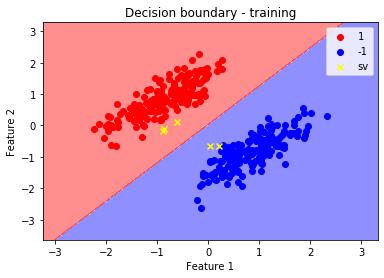

In [8]:
import matplotlib.pyplot as plt

pos_ind = np.where(y_train==1, True, False)
nega_ind = np.logical_not(pos_ind)

no_sv_ind = np.ones(X_train_std.shape[0], dtype=bool)
no_sv_ind[svc.index_support_vectors] = False

X_train_pos = X_train_std[np.logical_and(pos_ind, no_sv_ind)]
X_train_nega = X_train_std[np.logical_and(nega_ind, no_sv_ind)]
X_train_sv = X_train_std[svc.index_support_vectors]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - training')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c='red', label="1")
plt.scatter(X_train_nega[:, 0], X_train_nega[:, 1], c='blue', label="-1")
plt.scatter(X_train_sv[:, 0], X_train_sv[:, 1], c='yellow', marker='x', label="sv")

plt.legend()
plt.show()

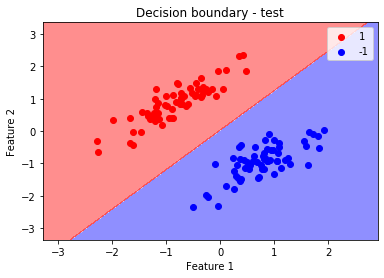

In [9]:
# test
x_min, x_max = X_test_std[:, 0].min() - 1, X_test_std[:, 0].max() + 1
y_min, y_max = X_test_std[:, 1].min() - 1, X_test_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = svc.predict(X_tmp).reshape(xx.shape)

X_test_pos = X_test_std[np.where(y_test==1)]
X_test_nega = X_test_std[np.where(y_test==-1)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], c='red', label="1")
plt.scatter(X_test_nega[:, 0], X_test_nega[:, 1], c='blue', label="-1")

plt.legend()
plt.show()

# 【問題6】
## （アドバンス課題）多項式カーネル関数の作成
最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。


「線形カーネルの式」

$$
k(x_i, x_j) = x_{i}^{T} x_j
$$

「多項式カーネルの式」

$$
k(x_i, x_j) = ({\gamma}x_{i}^{T} x_j + \theta_0)^{d}
$$

$γ, θ_0, d$はハイパーパラメータです。


線形カーネルは$γ=1, θ_0=0, d=1$の場合の多項式カーネルと等しいと言えます。

```python
    # set kernel
    if self.kernel == 'linear':
        _kernel = self._linear_kernel
    elif self.kernel == 'polynomical':
        _kernel = self._polynomical_kernel
    else:
        print(f'this model has no kernel named: {self._kernel}')
        _kernel = self._linear_kernel
```
```python
    def _polynomical_kernel(self, xi, xj):
        """
        多項式カーネル関数

        Parameters
        ----------
        xi, xj : 次の形のndarray, shape (n_features,)
            サンプル

        Returns
        -------
            int
            多項式カーネル関数の出力結果
        """
        k = (self.gamma*np.matmul(xi, xj.T)) + self.coef0)**self.degree

        return k
```

In [10]:
svc_poly = ScratchSVMClassifier(num_iter=3000, lr=0.002, kernel='polynomical', gamma=0.5, coef0=0.5, degree=3, threshold=1e-5, verbose=True)
svc_poly.fit(X_train_std, y_train)

 7
1892 num of sv: 7
1893 num of sv: 7
1894 num of sv: 7
1895 num of sv: 7
1896 num of sv: 7
1897 num of sv: 7
1898 num of sv: 7
1899 num of sv: 7
1900 num of sv: 7
1901 num of sv: 7
1902 num of sv: 7
1903 num of sv: 7
1904 num of sv: 7
1905 num of sv: 7
1906 num of sv: 7
1907 num of sv: 7
1908 num of sv: 7
1909 num of sv: 7
1910 num of sv: 7
1911 num of sv: 7
1912 num of sv: 7
1913 num of sv: 7
1914 num of sv: 7
1915 num of sv: 7
1916 num of sv: 7
1917 num of sv: 7
1918 num of sv: 7
1919 num of sv: 7
1920 num of sv: 7
1921 num of sv: 7
1922 num of sv: 7
1923 num of sv: 7
1924 num of sv: 7
1925 num of sv: 7
1926 num of sv: 7
1927 num of sv: 7
1928 num of sv: 7
1929 num of sv: 7
1930 num of sv: 7
1931 num of sv: 7
1932 num of sv: 7
1933 num of sv: 7
1934 num of sv: 7
1935 num of sv: 7
1936 num of sv: 7
1937 num of sv: 7
1938 num of sv: 7
1939 num of sv: 7
1940 num of sv: 7
1941 num of sv: 7
1942 num of sv: 7
1943 num of sv: 7
1944 num of sv: 7
1945 num of sv: 7
1946 num of sv: 7
1947 nu

In [11]:
y_pred_poly = svc_poly.predict(X_test_std)
print(y_pred_poly)
print(y_test)
print(f'confusion matrix:\n{confusion_matrix(y_test, y_pred_poly)}')

[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]
[-1  1 -1  1 -1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1
 -1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1  1  1  1
  1 -1  1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1 -1 -1  1 -1
  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1
  1  1  1  1 -1]
confusion matrix:
[[62  0]
 [ 0 63]]


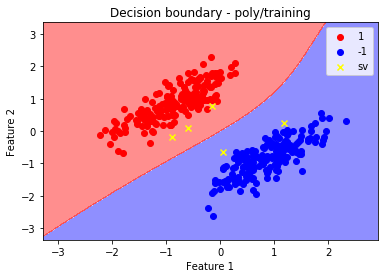

In [12]:
# poly/train
Z_poly = svc_poly.predict(X_tmp).reshape(xx.shape)

no_sv_ind[svc_poly.index_support_vectors] = False

X_train_pos = X_train_std[np.logical_and(pos_ind, no_sv_ind)]
X_train_nega = X_train_std[np.logical_and(nega_ind, no_sv_ind)]
X_train_sv = X_train_std[svc_poly.index_support_vectors]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - poly/training')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z_poly, cmap='bwr', alpha=0.5)
plt.scatter(X_train_pos[:, 0], X_train_pos[:, 1], c='red', label="1")
plt.scatter(X_train_nega[:, 0], X_train_nega[:, 1], c='blue', label="-1")
plt.scatter(X_train_sv[:, 0], X_train_sv[:, 1], c='yellow', marker='x', label="sv")

plt.legend()
plt.show()

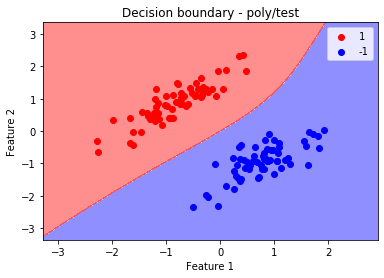

In [13]:
# poly/test
Z_poly = svc_poly.predict(X_tmp).reshape(xx.shape)

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - poly/test')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.contourf(xx, yy, Z_poly, cmap='bwr', alpha=0.5)
plt.scatter(X_test_pos[:, 0], X_test_pos[:, 1], c='red', label="1")
plt.scatter(X_test_nega[:, 0], X_test_nega[:, 1], c='blue', label="-1")

plt.legend()
plt.show()

検証に使ったデータが線形分割が容易なデータだったため、3次の決定境界についてもかなり直線に近くなった。



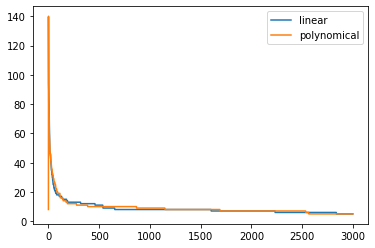

In [15]:
%matplotlib inline
plt.plot(svc.nsv_list, label='linear')
plt.plot(svc_poly.nsv_list, label='polynomical')
plt.legend()
plt.show()

図にプロットしたが、あまり違いは見られなかった。

カーネルの比較をする場合、線形分割不可能なデータで行う必要がある。